In [1]:
import ase.io as aio

import os
import numpy as np
import qml
import ase
import sys
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/hitp/')
sys.path.insert(0, '/home/sahre/git_repositories/APDFT/prototyping/atomic_energies/')
from prepare_calculations import *
import explore_qml_data as eqd
import utils_qm as uqm
import glob
import cpmd_io

from matplotlib import pyplot as plt

In /home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor rele

In [2]:
def sort_lambda_logfiles(search_dir):
    lambda_dirs = glob.glob(search_dir)
    sorted_lam_dirs = []
    sorted_lam_vals = []
    for l in lambda_dirs:
        lam_val = float(l.split('_')[-1])
        sorted_lam_dirs.append((lam_val, l))
        sorted_lam_vals.append(lam_val)
    sorted_lam_dirs.sort()
    sorted_lam_vals.sort()
    sorted_lam_vals = np.array(sorted_lam_vals)

    logfiles = []
    for lam in sorted_lam_dirs:
        if os.path.isfile(os.path.join(lam[1], 'run.log')):
            logfiles.append(os.path.join(lam[1], 'run.log'))
    return(sorted_lam_vals, logfiles)

def get_energy_contributions(logfiles):
    energy_contributions = {'TOTAL ENERGY =':[], 'KINETIC ENERGY =':[], 'ELECTROSTATIC ENERGY =':[], '(E+I)-(E+I) HARTREE ENERGY =':[], 
                   '(PSEUDO CHARGE I-I) ENERGY =':[], '(E-E) HARTREE ENERGY =':[], 'ESELF =':[], 'ESR =':[], 'LOCAL PSEUDOPOTENTIAL ENERGY =':[],
                   'N-L PSEUDOPOTENTIAL ENERGY =':[], 'EXCHANGE-CORRELATION ENERGY =':[], 'GRADIENT CORRECTION ENERGY =':[]}
    for p in logfiles:
        if os.path.isfile(p):
            with open(p, 'r') as f:
                logfile = f.readlines()

            for k in energy_contributions.keys():
                energy_contributions[k].append(cpmd_io.get_energy_contribution(logfile, k))

    for k in energy_contributions.keys():
        energy_contributions[k] = np.array(energy_contributions[k])

    nuc_rep_cpmd = energy_contributions['(PSEUDO CHARGE I-I) ENERGY ='] + energy_contributions['ESR ='] - energy_contributions['ESELF =']
    e_el_cpmd = energy_contributions['TOTAL ENERGY ='] - nuc_rep_cpmd
    return(energy_contributions, e_el_cpmd, nuc_rep_cpmd)

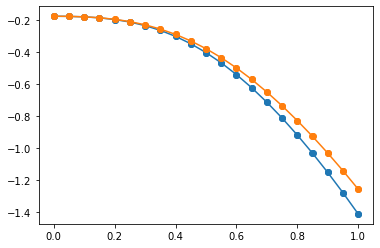

In [3]:
search_dir_H2 = '/data/sahre/projects/atomic-energies/derivatives/H2/small_dlambda/lam_*'
sorted_lam_vals_H2, logfiles_H2 = sort_lambda_logfiles(search_dir_H2)
energy_contributions_H2, e_el_cpmd_H2, nuc_rep_cpmd_H2 = get_energy_contributions(logfiles_H2)
e_tot_H2 = energy_contributions_H2["TOTAL ENERGY ="]
plt.plot(sorted_lam_vals_H2, e_el_cpmd_H2, '-o')

search_dir_H2_stretched = '/data/sahre/projects/atomic-energies/derivatives/H2/H2_stretched/lam_*'
sorted_lam_vals_H2_stretched, logfiles_H2_stretched = sort_lambda_logfiles(search_dir_H2_stretched)
energy_contributions_H2_stretched, e_el_cpmd_H2_stretched, nuc_rep_cpmd_H2_stretched = get_energy_contributions(logfiles_H2_stretched)
plt.plot(sorted_lam_vals_H2_stretched, e_el_cpmd_H2_stretched, '-o')

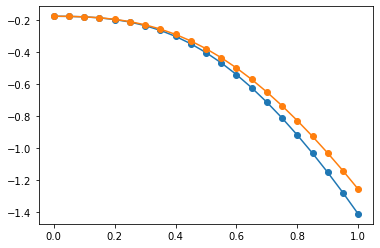

In [4]:
search_dir_partial2 = '/data/sahre/projects/atomic-energies/derivatives/H2/partial_derivatives/H2_lam_*'
sorted_lam_vals_partial2, logfiles_partial2  = sort_lambda_logfiles(search_dir_partial2)
energy_contributions_partial2, e_el_cpmd_partial2, nuc_rep_cpmd_partial2 = get_energy_contributions(logfiles_partial2)

search_dir_partial2_H2_stretched = '/data/sahre/projects/atomic-energies/derivatives/H2/partial_derivatives_stretched/H2_lam_*'
sorted_lam_vals_partial2_H2_stretched, logfiles_partial2_H2_stretched  = sort_lambda_logfiles(search_dir_partial2_H2_stretched)
energy_contributions_partial2_H2_stretched, e_el_cpmd_partial2_H2_stretched, nuc_rep_cpmd_partial2_H2_stretched = get_energy_contributions(logfiles_partial2_H2_stretched)

plt.plot(sorted_lam_vals_partial2, e_el_cpmd_partial2, '-o')
plt.plot(sorted_lam_vals_partial2_H2_stretched, e_el_cpmd_partial2_H2_stretched, '-o')

In [5]:
def calculate_partial_derivatives(lam_partial, lam_ref, e_partial, e_ref, dlam = 1e-5):
    dE_dZ = []
    for lam, e in zip(lam_partial, e_partial):
        lam0 = lam_ref[np.where(lam == lam_ref)[0]-1][0]
        e0 = e_ref[np.where(lam == lam_ref)[0]-1][0]
        dE_dZ.append((e-e0)/(lam-lam0))
    dE_dZ = np.array(dE_dZ)
    return(dE_dZ)

In [6]:
dE_dZ = calculate_partial_derivatives(sorted_lam_vals_partial2, sorted_lam_vals_H2, e_el_cpmd_partial2, e_el_cpmd_H2, dlam = 1e-5)
dE_dZ_H2_stretched = calculate_partial_derivatives(sorted_lam_vals_partial2_H2_stretched, sorted_lam_vals_H2_stretched, e_el_cpmd_partial2_H2_stretched, e_el_cpmd_H2_stretched, dlam = 1e-5)

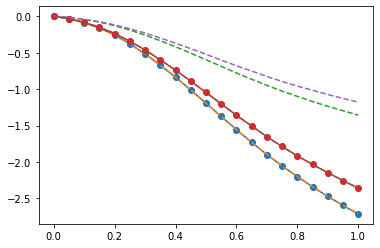

In [7]:
dE_dlam = []
ddlam = []
for i in range(0, len(sorted_lam_vals_H2), 2):
    dE_dlam.append((e_el_cpmd_H2[i+1]-e_el_cpmd_H2[i])/(sorted_lam_vals_H2[i+1]-sorted_lam_vals_H2[i]))
    ddlam.append((sorted_lam_vals_H2[i+1]+sorted_lam_vals_H2[i])/2)

dE_dlam_H2_stretched = []
ddlam_H2_stretched = []
for i in range(0, len(sorted_lam_vals_H2_stretched), 2):
    dE_dlam_H2_stretched.append((e_el_cpmd_H2_stretched[i+1]-e_el_cpmd_H2_stretched[i])/(sorted_lam_vals_H2_stretched[i+1]-sorted_lam_vals_H2_stretched[i]))
    ddlam_H2_stretched.append((sorted_lam_vals_H2_stretched[i+1]+sorted_lam_vals_H2_stretched[i])/2)
    
dE_dlam = np.array(dE_dlam)
ddlam = np.array(ddlam)
plt.plot(ddlam, dE_dlam, '-o')
plt.plot(ddlam, 2*dE_dZ, '--')
plt.plot(ddlam, dE_dZ, '--')

plt.plot(ddlam_H2_stretched, dE_dlam_H2_stretched, '-o')
plt.plot(ddlam_H2_stretched, dE_dZ_H2_stretched, '--')
plt.plot(ddlam_H2_stretched, 2*dE_dZ_H2_stretched, '--')

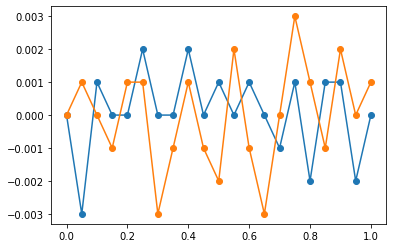

In [8]:
plt.plot(ddlam, dE_dlam-2*dE_dZ, '-o')
plt.plot(ddlam_H2_stretched, dE_dlam_H2_stretched-2*dE_dZ_H2_stretched, '-o')

In [9]:
E_int_dZ = 2*np.trapz(dE_dZ, ddlam)
E_int_dZ_H2_stretched = 2*np.trapz(dE_dZ_H2_stretched, ddlam_H2_stretched)

E_int_dlam = np.trapz(dE_dlam, ddlam)
E_int_dlam_H2_stretched = np.trapz(dE_dlam_H2_stretched, ddlam_H2_stretched)

E_exact = e_el_cpmd_H2[-2] - e_el_cpmd_H2[0]
E_exact_H2_stretched = e_el_cpmd_H2_stretched[-2] - e_el_cpmd_H2_stretched[0]

print(E_exact-E_int_dlam)
print(E_exact-E_int_dZ)
print(E_exact_H2_stretched-E_int_dlam_H2_stretched)
print(E_exact_H2_stretched-E_int_dZ_H2_stretched)

0.000547270005408329
0.000647270009241474
0.00043225000338775743
0.0004072500052052508


In [13]:
(E_int_dZ-E_int_dlam_H2_stretched)-(E_exact-E_exact_H2_stretched)

-0.0002150200058537166

In [12]:
(E_int_dZ-E_int_dZ_H2_stretched)-(E_exact-E_exact_H2_stretched)

-0.00024002000403622326

In [65]:
(nuc_rep_cpmd_H2[-2]+E_exact)-(e_tot_H2[-2]-e_tot_H2[0])

-1.1102230246251565e-16

In [67]:
(nuc_rep_cpmd_H2[-2]+E_int_dlam)-(e_tot_H2[-2]-e_tot_H2[0])

-0.0005472700054084401

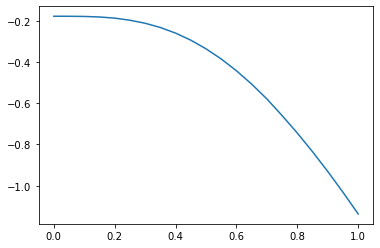

In [49]:
plt.plot(sorted_lam_vals_H2, e_tot_H2)

dE_dlam = []
ddlam = []
for i in range(0, len(sorted_lam_vals_H2), 2):
    dE_dlam.append((e_tot_H2[i+1]-e_tot_H2[i])/(sorted_lam_vals_H2[i+1]-sorted_lam_vals_H2[i]))
    ddlam.append((sorted_lam_vals_H2[i+1]+sorted_lam_vals_H2[i])/2)

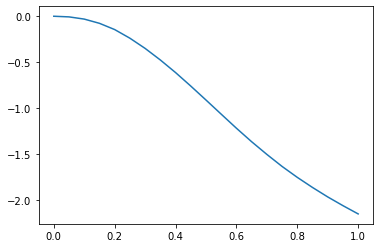

In [50]:
plt.plot(ddlam, dE_dlam)

In [39]:
(e_tot_H2[-2]-e_tot_H2[0]) - np.trapz(dE_dlam, ddlam)

-0.00274052999636476

-0.9588905299999999